# Девин Глеб Решение конкурса "Турникеты"

Импорты библиотек

In [1]:
import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import torch

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV
import optuna
import matplotlib.pyplot as plt
import os

Решение с помощью CatBoost, которое набирает 115 баллов. В этом подходе применяются OneHotEncoder для различных частей записи времени прохода через турникет и создаются категориальные признаки для параметров: часы, минуты, день недели, месяц и название ворот. Несмотря на детальную настройку гиперпараметров с помощью Optuna или GridSearch, результаты оказались недостаточно хорошими, и модель CatBoost не подошла для этой задачи.

In [2]:
# Определение базового пути к данным
base_path = 'data'

def load_csv(filename):
    file_path = os.path.join(base_path, filename)
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    else:
        raise FileNotFoundError(f"Файл {file_path} не найден.")

try:
    train_df = load_csv('train.csv')
    test_df = load_csv('test.csv')
    print("Файлы успешно загружены.")
except FileNotFoundError as e:
    print(e)


Файлы успешно загружены.


In [3]:
train_df.head(3)

,Unnamed: 0,user_id,ts,gate_id
0,0,18,2022-07-29 09:08:54,7
1,1,18,2022-07-29 09:09:54,9
2,2,18,2022-07-29 09:09:54,9


In [4]:
def preprocess(train, test):
    
    all_data = pd.concat([train, test], axis=0, ignore_index=True)
    all_data = all_data.drop(['Unnamed: 0'], axis=1)
    
    all_data['ts'] = pd.to_datetime(all_data['ts'])
    all_data = all_data.sort_values(by='ts')
    
    all_data['hour'] = all_data['ts'].dt.hour
    all_data['day'] = all_data['ts'].dt.day_name()
    all_data['month'] = all_data['ts'].dt.month_name()
    all_data['minute'] = all_data['ts'].dt.minute
    all_data['date'] = all_data['ts'].dt.day
    all_data['is_weekend'] = all_data['ts'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)

    columns_encode = ['minute','hour','day', 'month', 'date']
    encoder = OneHotEncoder()
   
    encoded_features = pd.DataFrame(encoder.fit_transform(all_data[columns_encode]).toarray(), 
                                    columns=encoder.get_feature_names_out(columns_encode))
    all_data = pd.concat([all_data, encoded_features], axis=1)

    all_data = all_data.drop(columns_encode, axis=1)
    
    train = all_data[all_data['user_word'].isna()]
    test = all_data[all_data['user_id'].isna()]
    
    train = train.drop(['user_word'], axis=1)
    test = test.drop(['user_id'], axis=1)
    
    train['user_id'] = train['user_id'].astype('int64')

    test_columns = test.columns.tolist()
    test_columns.remove('user_word')
    test_columns.remove('ts')

    train_colums = train.columns.tolist()
    train_colums.remove('ts')
    
    train[train_colums] = train[train_colums].astype('int64')
    #cols_to_convert = train.columns.difference(['ts'])
    #train[cols_to_convert] = train[cols_to_convert].astype('int64')
    #train = train.astype('int64')

    test[test_columns] = test[test_columns].astype('int64')
    
    
    return train, test


In [5]:
train_data, test_data = preprocess(train_df, test_df)
train_data.head(3)

,user_id,ts,gate_id,is_weekend,minute_0,minute_1,minute_2,minute_3,minute_4,minute_5,...,date_22,date_23,date_24,date_25,date_26,date_27,date_28,date_29,date_30,date_31
0,18,2022-07-29 09:08:54,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,18,2022-07-29 09:09:54,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,18,2022-07-29 09:09:54,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
print(train_data.shape)
test_data.shape

(37518, 131)


(7125, 131)

In [7]:
train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()

In [8]:
print(train_data.shape)
test_data.shape

(35172, 131)


(6620, 131)

In [9]:
train_data['gate_id'].value_counts() & test_data['gate_id'].value_counts()

C:\Users\Глеб\AppData\Local\Temp\ipykernel_11988\3511127123.py:1: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  train_data['gate_id'].value_counts() & test_data['gate_id'].value_counts()


gate_id
-1      True
 0     False
 1     False
 2     False
 3      True
 4      True
 5      True
 6      True
 7      True
 8      True
 9      True
 10     True
 11     True
 12     True
 13     True
 14     True
 15     True
 16    False
Name: count, dtype: bool

In [10]:
train_data['gate_id'].value_counts().iloc[-5:]

gate_id
8     24
1      5
16     4
0      2
14     1
Name: count, dtype: int64

В обучающей выборке отсутствует 2-й гейт, а в тестовой выборке отсутствуют 16-й и 0-й гейты. Имеет смысл удалить эти гейты из обучающей выборки. Кроме того, я удалил 14-й, 0-й и 1-й гейты, так как их представлено слишком мало как в обучающей, так и в тестовой выборке.

In [11]:
def del_gate(data, number_list):
    return data[~data['gate_id'].isin(number_list)]
list_gate_id_del = [ 0, 1, 2, 14, 16] #[0, 16] # 
train = del_gate(train_data, list_gate_id_del)
test=del_gate(test_data, list_gate_id_del)

In [12]:
train_data[train_data['gate_id']==2]

,user_id,ts,gate_id,is_weekend,minute_0,minute_1,minute_2,minute_3,minute_4,minute_5,...,date_22,date_23,date_24,date_25,date_26,date_27,date_28,date_29,date_30,date_31


In [13]:
test_data[test_data['gate_id']==2]

,ts,gate_id,user_word,is_weekend,minute_0,minute_1,minute_2,minute_3,minute_4,minute_5,...,date_22,date_23,date_24,date_25,date_26,date_27,date_28,date_29,date_30,date_31
39911,2023-01-13 16:49:52,2,categorical,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39912,2023-01-13 16:49:54,2,categorical,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39928,2023-01-13 18:21:16,2,categorical,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39929,2023-01-13 18:21:19,2,categorical,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
all_data = pd.concat([train_data, test_data], axis=0)

У нас есть данные с августа 2022 по март 2023 года, то есть всего 240 дней


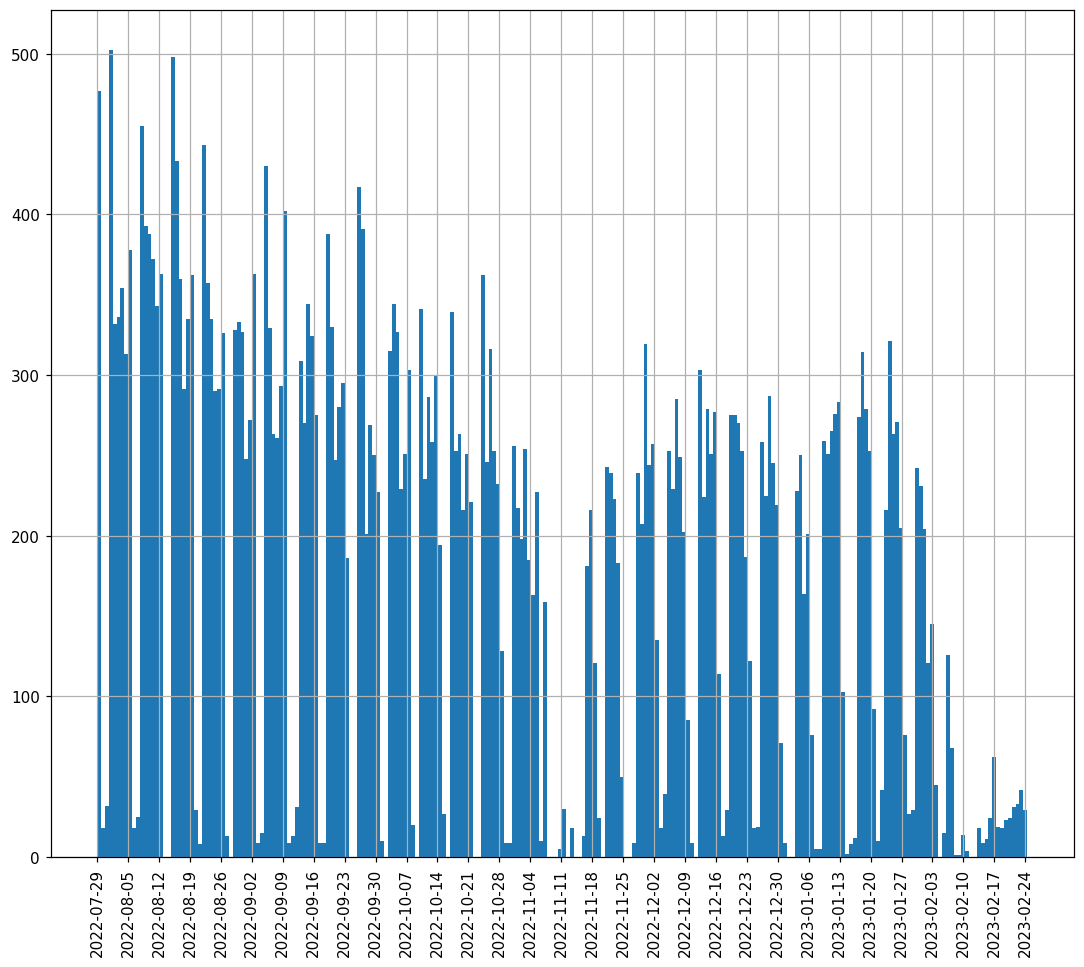

In [15]:
plt.figure(figsize=(12,10), dpi= 110)
plt.xticks(rotation='vertical')
all_data['ts'].hist(bins=240)

x_ticks = pd.date_range(start=all_data['ts'].min(), end=all_data['ts'].max(), freq='7D')
plt.xticks(x_ticks, rotation=90)

plt.show()


В выходные дни наблюдается меньший поток людей через турникеты, поэтому имеет смысл добавить признак, который будет указывать, был ли день выходным. Данных с меткой is_weekend насчитывается 945 записей(с дубликатами) и 811 записей без дубликатов.

In [16]:
train_data[train_data['is_weekend']==1].shape[0]

811

In [17]:
print(test_data.shape)
print(train_data.shape)

(6620, 131)
(35172, 131)


В данных присутствуют группы с небольшим числом примеров, такие как 5, 30, 52, 21, 44, 51 и 4. Я пробовал улучшить модель с помощью аугментации данных и применения весов для отдельных примеров, но это не дало удовлетворительных результатов. Поэтому я решил удалить из обучающей выборки классы с малым количеством примеров и итоговая метрика выросла

In [18]:
id_to_delete=[4, 51, 44, 21, 52,30] 
train_data = train_data[~train_data['user_id'].isin(id_to_delete)]

Для кетбуста выделим валидационную выборку(декабрь)

In [19]:
train_data[train_data['ts'] > '2022-11-30']
val_index = train_data['ts'] > '2022-11-30'
# train_data[train_data['ts'] > '2022-11-17']
# val_index = train_data['ts'] > '2022-12-17'
print(sum(val_index))
sum(val_index) / val_index.shape[0]

6526


0.185687864561104

In [20]:
X_train = train_data[~val_index].copy()
X_val = train_data[val_index].copy()

y_train = X_train['user_id']
y_val = X_val['user_id']

#X_train = X_train.drop(['user_id'], axis=1)
#X_val = X_val.drop(['user_id'],axis=1)
train_classes = set(y_train)
val_classes = set(y_val)

missing_classes = val_classes - train_classes
if missing_classes:
    print(f"Missing classes in train dataset: {missing_classes}")

X_train.head(3)
#Missing classes in train dataset: {2, 10, 44, 51, 21, 30}

Missing classes in train dataset: {2, 10}


,user_id,ts,gate_id,is_weekend,minute_0,minute_1,minute_2,minute_3,minute_4,minute_5,...,date_22,date_23,date_24,date_25,date_26,date_27,date_28,date_29,date_30,date_31
0,18,2022-07-29 09:08:54,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,18,2022-07-29 09:09:54,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,18,2022-07-29 09:10:06,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Как видно, в декабре отсутствуют данные по классам {2, 10, 44, 51, 21, 30}. Необходимо добавить эти классы в обучающую выборку

In [21]:
X_val[X_val['user_id'] == 44].index

Index([], dtype='int64')

In [22]:
def extend_train_val(X_train, y_train, X_val, y_val, user_ids, ratio=1.2):
    indices_to_add = []

    for user_id in user_ids:
        indices = X_val[X_val['user_id'] == user_id].index
        count = int(len(indices) // ratio)
        print(f'User ID {user_id}: Столько семплов пойдет в train {count}, Столько семплов всего {len(indices)}')

        for index in indices:
            if count > 0:
                indices_to_add.append(index)
                count -= 1

    X_train_extended = pd.concat([X_train, X_val.loc[indices_to_add]], axis=0)
    y_train_extended = pd.concat([y_train, y_val.loc[indices_to_add]], axis=0)

    indices_to_exclude = list(set(X_val.index) - set(indices_to_add))
    print(f'Индексы для исключения: {indices_to_add}, \nКоличество новых данных в обучение: {len(indices_to_add)} ')
    X_val_extended = X_val.loc[indices_to_exclude]
    y_val_extended = y_val.loc[indices_to_exclude]

    return X_train_extended, y_train_extended, X_val_extended, y_val_extended


In [23]:
#user_id которых не хватает 
user_ids = [*missing_classes]
X_train_extended, y_train_extended, X_val_extended, y_val_extended = extend_train_val(
    X_train, y_train, X_val, y_val, user_ids
)


User ID 2: Столько семплов пойдет в train 32, Столько семплов всего 39
User ID 10: Столько семплов пойдет в train 14, Столько семплов всего 17
Индексы для исключения: [36781, 36782, 36785, 36786, 36824, 36825, 36826, 36827, 36867, 36868, 36869, 36955, 36956, 36957, 36958, 37046, 37047, 37048, 37069, 37070, 37071, 37072, 37171, 37172, 37173, 37251, 37252, 37253, 37254, 37345, 37346, 37347, 30741, 30742, 30743, 30832, 30833, 32161, 32162, 32270, 32271, 32272, 32274, 32275, 32276, 32277], 
Количество новых данных в обучение: 46 


Проверяем что удалили данные из валидации, чтобы обьективно оценивать модель

In [24]:
print(X_val_extended.shape[0])
print(X_val.shape[0])

6480
6526


In [25]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)

for train_index, val_index in tscv.split(train_data):
    print('train_index:', train_index, 'val_index:', val_index)
    X_train, X_val = train_data.iloc[train_index], train_data.iloc[val_index]
    y_train, y_val = X_train['user_id'], X_val['user_id']

    train_classes = set(y_train)
    val_classes = set(y_val)

    missing_classes = val_classes - train_classes
    if missing_classes:
        print(f"Missing classes in train dataset: {missing_classes}")
    print('Next iter')


train_index: [   0    1    2 ... 5857 5858 5859] val_index: [ 5860  5861  5862 ... 11714 11715 11716]
Missing classes in train dataset: {42, 28, 36, 7}
Next iter
train_index: [    0     1     2 ... 11714 11715 11716] val_index: [11717 11718 11719 ... 17571 17572 17573]
Missing classes in train dataset: {14}
Next iter
train_index: [    0     1     2 ... 17571 17572 17573] val_index: [17574 17575 17576 ... 23428 23429 23430]
Missing classes in train dataset: {17, 35}
Next iter
train_index: [    0     1     2 ... 23428 23429 23430] val_index: [23431 23432 23433 ... 29285 29286 29287]
Missing classes in train dataset: {5, 38, 41, 10, 43}
Next iter
train_index: [    0     1     2 ... 29285 29286 29287] val_index: [29288 29289 29290 ... 35142 35143 35144]
Missing classes in train dataset: {2}
Next iter


In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
train_classes = set(y_train_extended)
val_classes = set(y_val_extended)

missing_classes = val_classes - train_classes
if missing_classes:
    print(f"Missing classes in train dataset: {missing_classes}")

In [28]:
# from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
# from hyperopt.pyll.base import scope

# X_train_cat, X_test_cat, y_train_cat, y_test_cat = X_train_extended.drop('user_id', axis=1),\
#                                         X_val_extended.drop('user_id', axis=1), \
#                                         y_train_extended, y_val_extended

# train_pool = Pool(
#     data=X_train_cat,
#     label=y_train_cat
# )
# test_pool = Pool(
#     data=X_test_cat, 
#     label=y_test_cat
# )

# def objective(params):
#     model = CatBoostClassifier(**params, task_type='GPU')
    
#     model.fit(train_pool, eval_set=(test_pool), verbose=100)
    
    
#     y_pred = model.predict(test_pool)
#     accuracy = accuracy_score(y_test_cat, y_pred)
    
#     return {'loss': -accuracy, 'status': STATUS_OK}

# # Пространство поиска всех гиперпараметров
# space = {
#     'depth': hp.quniform('depth', 1, 6, 1),
#     'learning_rate': hp.loguniform('learning_rate', -3, 0),
#     'l2_leaf_reg': hp.loguniform('l2_leaf_reg', -3, 3),
#     'iterations': hp.quniform('iterations', 100, 5000, 100),
#     'border_count': hp.quniform('border_count', 1, 255, 1)
# }


# # Запуск оптимизации гиперпараметров
# trials = Trials()
# best = fmin(objective, space, algo=tpe.suggest, max_evals=20, trials=trials)

# print(best)


In [29]:

# accuracy_scores = []

# models = []

# X_train_cat, X_test_cat, y_train_cat, y_test_cat = X_train_extended.drop('user_id', axis=1),\
#                                         X_val_extended.drop('user_id', axis=1), \
#                                         y_train_extended, y_val_extended
# #X_train_extended, y_train_extended, X_val_extended, y_val_extended

# model = CatBoostClassifier(
#     iterations = 4300,
#     depth=6,
#     learning_rate=0.11,
#     l2_leaf_reg = 0.527,
#     thread_count = 14,
#     early_stopping_rounds=2000,
#     loss_function='MultiClass',
#     task_type="GPU", 
#     random_seed=42
# )
# train_pool = Pool(
#     data=X_train_cat,
#     label=y_train_cat
# )
# test_pool = Pool(
#     data=X_test_cat, 
#     label=y_test_cat
# )


# model.fit(train_pool, eval_set=(test_pool), verbose=333)
# models.append(model)

# y_pred = model.predict(X_val)



# accuracy_score_val = accuracy_score(y_val, y_pred)

# accuracy_scores.append(accuracy_score_val)

# print(f"Accuracy Score for current: {accuracy_score_val}")


Я провел эксперименты с моделями машинного обучения, такими как логистическая регрессия, нейронные сети, которые хорошо работают с временными рядами (RNN, GRU и LSTM) и градиентный бустинг (в частности CatBoost, LightGBM и XGBoost). Однако ни один из этих подходов не показал результатов лучше, чем RandomForest.

Решение на основе RandomForestClassifier

In [30]:
# X_train, X_test, y_train, y_test = X_train_extended.drop(['ts','user_id'],axis=1), X_val_extended.drop(['ts','user_id'],axis=1), y_train_extended, y_val_extended

# rf = RandomForestClassifier(random_state=42)

# param_grid = {
#     'n_estimators': [100, 300, 600, 700],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [3, 5, 10],
#     'max_features': ['sqrt', 'log2', None],
#     'bootstrap': [True, False],  # Использование метода бутстрапа при построении деревьев
#     'class_weight': [None, 'balanced', 'balanced_subsample'],  # Взвешивание классов
#     'criterion': ['gini', 'entropy', 'log_loss'],  # Критерии оценки качества разбиений

# }

# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=2)

# grid_search.fit(X_train, y_train)

# # Вывод лучших гиперпараметров и лучшего результата
# print("Лучшие параметры:", grid_search.best_params_)
# print("Лучшее значение метрики:", grid_search.best_score_)

# # Оценка на тестовых данных
# test_accuracy = grid_search.score(X_test, y_test)
# print(f"Точность на тестовых данных: {test_accuracy:.4f}")


In [31]:
model_best_rf = RandomForestClassifier(random_state=42, min_samples_split=3,
                                    n_estimators=600, max_depth=None, bootstrap=False, 
                                    max_features='log2', criterion= 'gini',class_weight=None)

In [32]:
model_best_rf.fit(X_train_extended.drop(['ts','user_id','is_weekend'],axis=1), y_train_extended)

RandomForestClassifier(bootstrap=False, max_features='log2',
                       min_samples_split=3, n_estimators=600, random_state=42)

In [33]:
y_test = test_data['user_word']
X_test = test_data.drop(['user_word','ts','is_weekend'], axis=1)
X_test.head(3)

,gate_id,minute_0,minute_1,minute_2,minute_3,minute_4,minute_5,minute_6,minute_7,minute_8,...,date_22,date_23,date_24,date_25,date_26,date_27,date_28,date_29,date_30,date_31
37518,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37520,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37521,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
y_pred = model_best_rf.predict(X_test)
print(y_test.shape)
y_pred

(6620,)


array([ 3,  3,  3, ..., 54, 54, 37], dtype=int64)

In [35]:
result = pd.DataFrame({'user_word': y_test, 'preds': y_pred})
result.groupby('user_word').agg(lambda x: x.value_counts().index[0])

,preds
user_word,
aucroc,49
binary,12
blue,37
categorical,37
coefficient,15
collinear,55
distributed,37
epsilon,1
f1,18


Придумал метод для удаление дубликатов из ответа

In [36]:
def find_key(dictionary, search_value):
    return next((key for key, val in dictionary.items() if val == search_value), None)

def update_word_frequencies(word_list, word_id_mapping, word_frequency_mapping, current_identifier):
    frequency_counter = {}
    
    for word in word_list:
        frequency_counter[word] = frequency_counter.get(word, 0) + 1

    sorted_frequencies = sorted(frequency_counter.items(), key=lambda item: item[1], reverse=True)
    for word, count in sorted_frequencies:
        existing_key = find_key(word_id_mapping, current_identifier)
        existing_freq = word_frequency_mapping.get(existing_key, 0) if existing_key else 0

        if count > word_frequency_mapping.get(word, 0) and count > existing_freq:
            word_id_mapping[word] = current_identifier
            word_frequency_mapping[word] = count
        else:
            pass
    return word_id_mapping, word_frequency_mapping
unique_words_list = result['user_word'].unique()
unique_ids_set = result['preds'].unique()
word_id_map = {word: -999 for word in unique_words_list}
word_freq_map = {word: 0 for word in unique_words_list}

id_set = {37, 55, 6, 12, 19, 15, 18, 47, 53, 1, 33, 11, 49, 0, 39, 32, 54, 9, 50, 29, 3, 48, 14, 17, 27, 35, 57, 24, 42, 26, 34, 23, 25, 40, 31, 56, 41, 43, 22, 28, 45, 7, 36, 2, 8, 10, 38, 5, 21, 51, 4
}
for current_id in unique_ids_set:
    if current_id in id_set:
        words_related = result[result['preds'] == current_id]['user_word'].tolist()
        word_id_map, word_freq_map = update_word_frequencies(words_related, word_id_map, word_freq_map, current_id)


In [37]:
submit = pd.DataFrame(word_id_map.items(), columns=['user_word', 'preds'])
submit = submit.sort_values(by='user_word')
submit

,user_word,preds
21,aucroc,34
10,binary,12
15,blue,-999
19,categorical,14
30,coefficient,26
13,collinear,55
25,distributed,22
1,epsilon,1
8,f1,18
2,fit,0


In [38]:
submit.to_csv('answer.csv', index=False)

Выдает 184 скор

Увеличим количество признаков для RandomForest

In [39]:
train_data['user_id'].value_counts().iloc[-8:]

user_id
45    57
7     48
36    45
2     39
8     27
10    17
38    13
5     10
Name: count, dtype: int64

In [40]:
id_to_delete=[4, 51, 44, 21, 52,30] 
train_data = train_data[~train_data['user_id'].isin(id_to_delete)]

In [41]:
clf = RandomForestClassifier(random_state=42, min_samples_split=3,
                                    n_estimators=600, max_depth=None, bootstrap=False, 
                                    max_features='log2', criterion= 'gini',class_weight=None)

In [42]:
#clf = RandomForestClassifier(criterion='gini', max_depth=50,  max_features='log2', n_estimators=50, random_state=1)
clf.fit(X_train_extended.drop(['ts','user_id','is_weekend'],axis=1), y_train_extended)

RandomForestClassifier(bootstrap=False, max_features='log2',
                       min_samples_split=3, n_estimators=600, random_state=42)

In [43]:
y_test = test_data['user_word']
X_test = test_data.drop(['user_word','ts','is_weekend'], axis=1)
X_test.head(3)
y_test_pred = clf.predict(X_test)

In [44]:
y_test_pred

array([ 3,  3,  3, ..., 54, 54, 37], dtype=int64)

In [45]:
result = pd.DataFrame({'user_word': y_test, 'preds': y_test_pred})
result.groupby('user_word').agg(lambda x: x.value_counts().index[0])

,preds
user_word,
aucroc,49
binary,12
blue,37
categorical,37
coefficient,15
collinear,55
distributed,37
epsilon,1
f1,18


In [46]:
submit = pd.DataFrame(word_id_map.items(), columns=['user_word', 'preds'])
submit = submit.sort_values(by='user_word')
submit

,user_word,preds
21,aucroc,34
10,binary,12
15,blue,-999
19,categorical,14
30,coefficient,26
13,collinear,55
25,distributed,22
1,epsilon,1
8,f1,18
2,fit,0


In [47]:
# submit.to_csv('answer12.csv', index=False)

In [48]:
# !zip answer12.zip answer12.csv 

Увеличиваем количество признаков

In [67]:
train_df = load_csv('train.csv')
test_df = load_csv('test.csv')

In [50]:
def vector_creation(data,gate_cols):
    for col in gate_cols:
        data[col] = data[col].astype('int64')
        vectorizer = CountVectorizer(ngram_range=(1, 2))
        data[col] = data[col].astype(str)
        vectorized_data = vectorizer.fit_transform(data[col])
        df_vectorized = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(col))
        data = pd.concat([data, df_vectorized], axis=1)
    return data

In [51]:
def process_submit(submit, word_id):
    while True:
        flag = True

        for index in range(len(submit)):
            
            pred = submit['preds'][index]
            if pred == -999:
                continue
            
            maxx = submit['predict_prob'][index]
            index_max_probability = index
            repeat_index = [index]

            for i in range(len(submit)):
                if i != index:
                    if pred == submit['preds'][i]:
                        flag = False
                        repeat_index.append(i)
                        if maxx < submit['predict_prob'][i]:
                            maxx = submit['predict_prob'][i]
                            index_max_probability = i

            if not flag:
                word_max_probability = submit['user_word'][index_max_probability]
                emptys = []
                
                for key, value in word_id.items():
                    if key!=word_max_probability:
                        if len(value)>1:
                            value.pop(0)
                        elif len(value)==1:
                            value.pop(0)
                            emptys.append(key)
                        else:
                            emptys.append(key)

                for i in repeat_index:
                    if i!=index_max_probability:
                        if submit['user_word'][i] not in emptys:
                            submit['preds'][i] = word_id[submit['user_word'][i]][0]['id']
                            submit['predict_prob'][i] = word_id[submit['user_word'][i]][0]['frequency']
                        else:
                            submit['preds'][i] = -999
        if flag:
            break
    return submit, word_id

In [52]:
def preprocess_data(data):
    data = data.drop(['Unnamed: 0'], axis=1)
    data['ts'] = pd.to_datetime(data['ts'])
    data = data.sort_values(by='ts')
    data['minute'] = data['ts'].dt.minute
    data['hour'] = data['ts'].dt.hour
    data['day'] = data['ts'].dt.day
    data['dayweek'] = data['ts'].dt.dayofweek
    data['month'] = data['ts'].dt.month
    data['second'] = data['ts'].dt.second
    data['minute_from_start'] = data['hour']*60 + data['minute']
    data['seconds_from_start'] = data['minute_from_start']*60 + data['second']
    data['weekend'] = (data['dayweek'] // 5 == 1).astype(int)
    data = data.drop(['ts'], axis=1)
    return data

In [53]:
def one_hot(train, test):
    data = pd.concat([train, test], axis=0, ignore_index=True)
    columns_encode = ['hour','gate_id', 'dayweek']
    gate_cols = ['gate_-5','gate_-4','gate_-3','gate_-2','gate_-1','gate_1','gate_2','gate_3','gate_4','gate_5']

    encoder = OneHotEncoder()
    encoded_features = pd.DataFrame(encoder.fit_transform(data[columns_encode]).toarray(), columns=encoder.get_feature_names_out(columns_encode))
    data = pd.concat([data, encoded_features], axis=1)
    data = data.drop(columns_encode, axis=1)

    data = vector_creation(data,gate_cols)
    
    X = data[data['user_word'].isna()]
    y = data[data['user_id'].isna()]
    X = X.drop(['user_word'], axis=1)
    X['user_id'] = X['user_id'].astype('int64')
    y = y.drop(['user_id'], axis=1)
    y_columns = y.columns.tolist()
    y_columns.remove('user_word')
    X = X.astype('int64')
    return X, y

def preprocess(data, is_test = 'user_id'):
    gates=[-5,-4,-3,-2,-1,0,1,2,3,4,5]
    data  = preprocess_data(data)
    count_ts = 0

    for i in gates:
        if i!=0:
            data['gate_'+str(i)] = data.groupby(is_test)['gate_id'].shift(i)
            data['gate_'+str(i)].fillna(-2, inplace=True)
            data['gate_'+str(i)] = data['gate_'+str(i)].astype('int64')
        if i>-5:
            data['ts_'+str(count_ts)] = np.abs(data.groupby(is_test)['seconds_from_start'].shift(i-1) - data.groupby(is_test)['seconds_from_start'].shift(i))
            data['ts_'+str(count_ts)].fillna(-1, inplace=True)
            data['ts_'+str(count_ts)] = data['ts_'+str(count_ts)].astype('int64')
            count_ts+=1
    return data

In [54]:
train_df = preprocess(train_df)
test_df = preprocess(test_df, is_test='user_word')


In [55]:
train_data, test_data = one_hot(train_df, test_df)
train_data.head(2)

,user_id,minute,day,month,second,minute_from_start,seconds_from_start,weekend,gate_-5,gate_-4,...,14,15,16,10,11,12,13,14,15,16
0,18,8,29,7,54,548,32934,0,10,5,...,0,0,0,0,0,0,0,0,0,0
1,18,9,29,7,54,549,32994,0,11,10,...,0,0,0,0,0,0,0,0,0,0


In [56]:
model_best = RandomForestClassifier(random_state=42)

In [57]:
# model_best = RandomForestClassifier(random_state=42, min_samples_split=3,
#                                   n_estimators=600, max_depth=None, bootstrap=False, 
#                                    max_features='log2', criterion= 'gini',class_weight=None)

In [58]:
y = train_data['user_id']
X = train_data.drop(['user_id'], axis=1)

In [59]:
model_best.fit(X, y)

RandomForestClassifier(random_state=42)

In [60]:
y_test = test_data['user_word']
X_test = test_data.drop(['user_word'], axis=1)

In [61]:
y_pred = model_best.predict(X_test)

In [62]:
def create_final_submit(result, bad_ids):
    uniq_words = result['user_word'].unique()

    submit = pd.DataFrame({'user_word': uniq_words, 'preds': -999, 'predict_prob': 0})
    submit = submit.sort_values(by='user_word')


    word_id = {word_i: [] for word_i in uniq_words}
    for word in uniq_words:
        ids = result[result['user_word'] == word]['preds'].tolist()
        for item in bad_ids:
            while item in ids:
                ids.remove(item)
        unique_ids = np.unique(ids)

        probabilty = []

        for id in unique_ids:
            frequency = ids.count(id)/len(ids)
            probabilty.append({'id': id, 'frequency': frequency})
        probabilty = sorted(probabilty, key=lambda x: x['frequency'], reverse=True)
        word_id[word] = probabilty
        
    submit = submit.reset_index(drop=True)

    for index in range(len(submit)):
        try:
            submit['preds'][index] = word_id[submit['user_word'][index]][0]['id']
            submit['predict_prob'][index] = word_id[submit['user_word'][index]][0]['frequency']
        except IndexError:
            submit['preds'][index] = -999
            submit['predict_prob'][index] = 0
    return submit, word_id

In [63]:
result = pd.DataFrame({'user_word': y_test, 'preds': y_pred})
bad_ids = [49, 22, 26, 46, 51, 52]

In [64]:
submit, word_id = create_final_submit(result, bad_ids)
submit

,user_word,preds,predict_prob
0,aucroc,24,1.000000
1,binary,12,0.817481
2,blue,12,0.416667
3,categorical,14,0.643411
4,coefficient,15,0.290323
5,collinear,12,0.147692
6,distributed,0,0.434426
7,epsilon,1,0.372951
8,f1,6,0.350000
9,fit,15,0.267016


In [65]:
submit, word_id = process_submit(submit, word_id)
submit = submit.drop('predict_prob',axis=1)
submit

,user_word,preds
0,aucroc,24
1,binary,12
2,blue,-999
3,categorical,14
4,coefficient,-999
5,collinear,-999
6,distributed,0
7,epsilon,1
8,f1,6
9,fit,17


# Лучший скор 262

In [66]:
submit.to_csv('answer.csv', index=False)

In [68]:
!zip answer.zip answer.csv 

updating: answer.csv (284 bytes security) (deflated 39%)
